In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.decomposition import FastICA
from sklearn import preprocessing
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, homogeneity_score, silhouette_score, classification_report
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
import warnings
from scipy.stats import kurtosis
import time
warnings.filterwarnings("ignore")

In [2]:
dataset_select =     0    # 0 for wine , 1 for cancer

In [3]:
if dataset_select == 0:
    wine = pd.read_csv('data/wine.csv',sep=';')
    print('Wine Quality Dataset')
    print(wine.shape)
    bins = (2, 6.5, 8)
    group_names = ['bad','good']
    wine['quality'] = pd.cut(wine['quality'], bins=bins,labels=group_names)
    wine = wine.dropna()
    wine_label_quality = LabelEncoder()
    wine['quality'] = wine_label_quality.fit_transform(wine['quality'])
    df = wine
    X = wine.drop('quality',axis=1)
    y = wine['quality']
    dataset='wine'
    ncomp = 7
elif dataset_select == 1:
    print('Cancer Dataset')
    cancer = pd.read_csv('data/cancer.csv')
    print(cancer.shape)
    cancer = cancer.dropna()
    cancer['class']=cancer['class'].map({4:1, 2:0})
    df = cancer
    X = cancer.drop(['id','class'],axis=1)
    y = cancer['class'] 
    dataset='cancer'
    ncomp = 3
else:
    raise Exception('dataset_select field must be 0 for wine , 1 for cancer')

X = MinMaxScaler().fit_transform(X)


Wine Quality Dataset
(4898, 12)


In [4]:
ica_7 = FastICA(n_components=10, random_state=44)
ica_7.fit(X)
X_ica_7 = ica_7.transform(X)

n_comp: 0kurt: 42.72612302487439
n_comp: 1kurt: 2.1426589025752003
n_comp: 2kurt: 5.102236746488812
n_comp: 3kurt: 15.660542490509627
n_comp: 4kurt: 1.8903616004626587
n_comp: 5kurt: 2.349993123723543
n_comp: 6kurt: -0.872804075158395
n_comp: 7kurt: 3.8461240311707794
n_comp: 8kurt: 6.328314531943466
n_comp: 9kurt: 0.8757226667987061


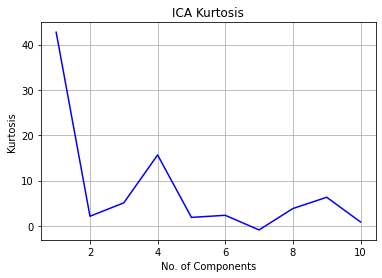

In [5]:
k = kurtosis(X_ica_7)
for t in range(len(k)):
    print("n_comp: "+str(t)+"kurt: "+str(k[t]))
plt.figure()
plt.plot(np.arange(1,len(k)+1,1),k, color='b')
plt.xlabel('No. of Components')
plt.ylabel('Kurtosis')
plt.title('ICA Kurtosis')
plt.grid()
plt.savefig('img/ica kurtosis '+dataset+'.png')
plt.show()

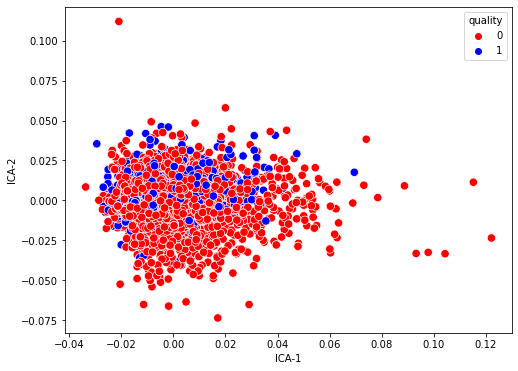

In [6]:
ica_7 = FastICA(n_components=ncomp, random_state=44)
ica_7.fit(X)
X_ica_7 = ica_7.transform(X)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_ica_7[:, 0],
                y=X_ica_7[:,1],
                s = 70,
                hue=y,
                palette=['red','blue'])
plt.xlabel('ICA-1')
plt.ylabel('ICA-2')
plt.savefig('img/2d ICA cluster '+dataset+'.png')
plt.show()

Text(0.5, 1.0, 'ICA recovered signals')

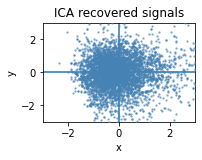

In [7]:
def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver((0, 0), (0, 0), x_axis, y_axis, zorder=11, width=0.01,
                       scale=6, color=color)

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')
X_ica_ = X_ica_7
X_ica_ /= X_ica_7.std(axis=0)
plt.subplot(2, 2, 4)
plot_samples(X_ica_ / np.std(X_ica_))
plt.title('ICA recovered signals')

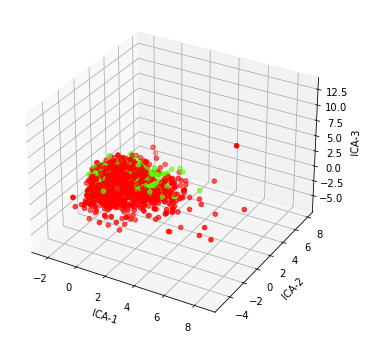

In [8]:
ax = plt.figure(figsize=(8,6)).gca(projection='3d')
ax.scatter(
    xs=X_ica_7[:, 0], 
    ys=X_ica_7[:, 1], 
    zs=X_ica_7[:, 2], 
    c=y, 
    cmap='prism'
)
ax.set_xlabel('ICA-1')
ax.set_ylabel('ICA-2')
ax.set_zlabel('ICA-3')
plt.savefig('img/3d ICA cluster '+dataset+'.png')
plt.show()

In [9]:
N = np.arange(2, 41, 1)
S,H = [],[]
for n in N:
    km = KMeans(n_clusters=n,
                    n_init=50,
                    max_iter=1000,
                    random_state=44).fit(X_ica_7)
    S.append(silhouette_score(X, km.labels_, metric='euclidean'))
    H.append(homogeneity_score(y, km.labels_))

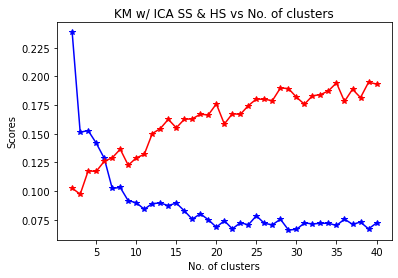

In [10]:
plt.figure()
plt.plot(N, S, '*-',color='b',label='Silhouette')
plt.plot(N, H, '*-',color='r',label='Homogeneity')
plt.title('')
plt.xlabel('No. of clusters')
plt.ylabel('Scores')
plt.title('KM w/ ICA SS & HS vs No. of clusters')
plt.savefig('img/KM ICA Scores '+dataset+'.png')
plt.show()

In [11]:
S, H, L = [],[],[]
for n in N:
    gmm = GaussianMixture(n_components=n,
                          max_iter=100,
                          random_state=44, 
                          n_init=5).fit(X_ica_7)
    l = gmm.predict(X_ica_7)
    S.append(silhouette_score(X, l, metric='euclidean'))
    H.append(homogeneity_score(y, l))
    L.append(gmm.score(X_ica_7))

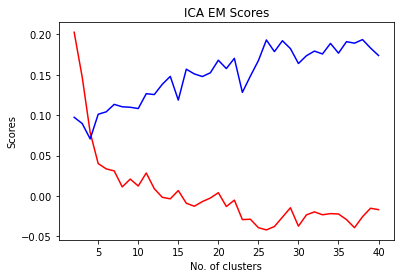

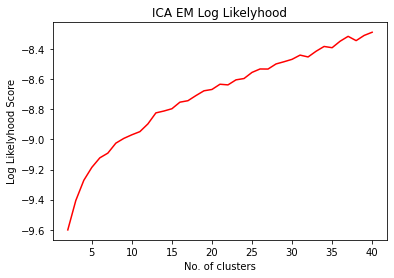

In [12]:
plt.figure()
plt.plot(N, S, color='r')
plt.plot(N, H, color='b')
plt.title('ICA EM Scores')
plt.xlabel('No. of clusters')
plt.ylabel('Scores')
plt.savefig('img/EM ICA Scores '+dataset+'.png')
plt.show()

plt.figure()
plt.plot(N, L, color='r')
plt.title('ICA EM Log Likelyhood')
plt.xlabel('No. of clusters')
plt.ylabel('Log Likelyhood Score')
plt.savefig('img/EM ICA Log '+dataset+'.png')
plt.show()

Fit Time
3.8896286487579346
Tuned Accuracy: 81.81%
[learning_curve] Training set sizes: [ 274  548  822 1096 1370 1644 1918 2192 2466 2740]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  17 out of  50 | elapsed:   19.4s remaining:   37.7s
[Parallel(n_jobs=2)]: Done  34 out of  50 | elapsed:   38.3s remaining:   18.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   58.8s finished


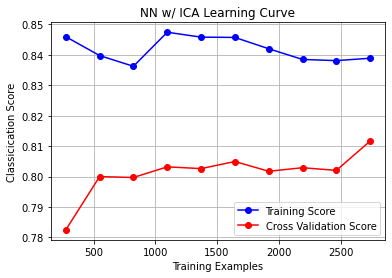

No handles with labels found to put in legend.


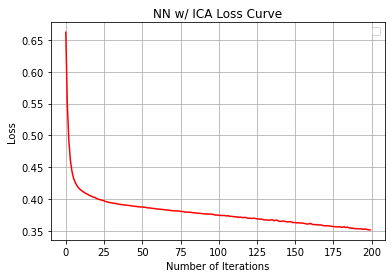

In [13]:

if dataset_select == 0:
    X_train, X_test, y_train, y_test = train_test_split(X_ica_7, 
                                                        y, 
                                                        test_size=0.3, 
                                                        random_state=42,
                                                        stratify=y)
    nn_clf = MLPClassifier()
    st =time.time()
    nn_clf.fit(X_train, y_train)
    print('Fit Time')
    print(time.time()-st)
    nn_y_pred = nn_clf.predict(X_test)
    nn_acc = accuracy_score(y_test, nn_y_pred)*100
    print("Tuned Accuracy: %.2f%%"%nn_acc)
    train_sizes, nn_train_scores, test_scores = learning_curve(nn_clf,
                                                               X_train,
                                                               y_train,
                                                               train_sizes=np.linspace(0.1,1.0,10),
                                                               verbose=3,
                                                               n_jobs=2)
    plt.figure()
    plt.plot(train_sizes, np.mean(nn_train_scores, axis=1),'o-',
            label='Training Score',color='blue')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-',
            label='Cross Validation Score',color='red')
    plt.title('NN w/ ICA Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Classicication Score')
    plt.legend()
    plt.grid()
    plt.savefig('img/ICA_NN_learning '+dataset+'.png')
    plt.show()
    nn_loss= nn_clf.loss_curve_
    plt.figure()
    plt.title('NN w/ ICA Loss Curve')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    plt.plot(nn_loss, '-', color='red')
    plt.grid()
    plt.legend()
    plt.savefig('img/ICA_NN_loss '+dataset+'.png')
    plt.show()